# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [3]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier()),
    ])
params = {
    'clf__weights': ['uniform','distance'],
    'clf__p': [1,2],
    'clf__n_neighbors': list(range(1,21)),
    }
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__weights': 'uniform'}
0.7683743403152125


In [34]:
pred = grid.predict(X)

In [35]:
#confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, pred)
cm

array([[5599, 1272],
       [1597, 5274]], dtype=int64)

In [36]:
df_cm=pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
df_cm

,0,1
0,5599,1272
1,1597,5274


In [69]:
tpr = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
fpr = df_cm.loc[0,1] / (df_cm.loc[0,1] + df_cm.loc[1,1])
precision = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[0,1])
recall = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
f = (2 * (precision * recall)) / (precision + recall)
print(tpr, fpr, precision, recall, f)

0.778071150639244 0.19431714023831348 0.8148741085722602 0.778071150639244 0.7960474870263738


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y, grid.predict(X)))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      6871
           1       0.81      0.77      0.79      6871

    accuracy                           0.79     13742
   macro avg       0.79      0.79      0.79     13742
weighted avg       0.79      0.79      0.79     13742



# 시각화

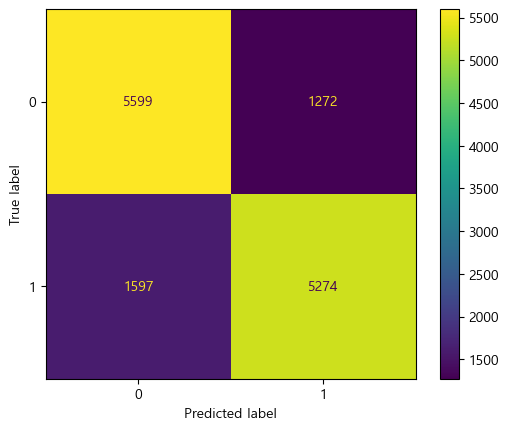

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_).plot()

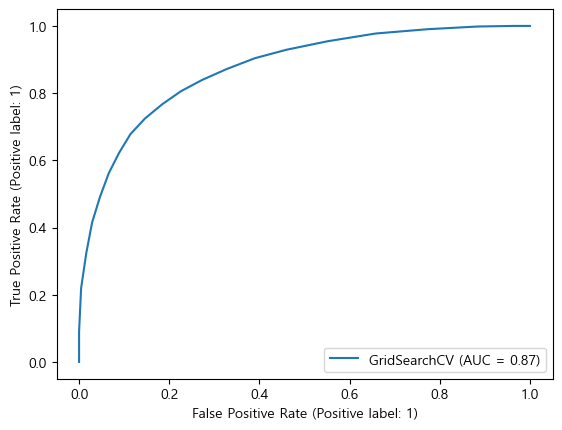

In [39]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid, X, y)
# auc = 0.87

# 저장

In [73]:
result = pd.read_csv('../csv/model_results.csv')
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87


In [71]:
if 'KNN' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('KNN')] = ['KNN', grid.best_score_, grid.best_params_, precision, recall, f, tpr, fpr, 0.87]
else:
    result.loc[len(result.index)] = ['KNN', grid.best_score_, grid.best_params_, precision, recall, f, tpr, fpr, 0.87]
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87


In [72]:
result.to_csv('../csv/model_results.csv', index=None)

In [63]:
import joblib
model = grid.best_estimator_['clf']
joblib.dump(model, 'c:/bank_account_fraud/model/knn.h5')

['c:/bank_account_fraud/model/knn.h5']

In [64]:
# 스케일러 저장
scaler = StandardScaler()
scaler.fit(X)
joblib.dump(scaler, '../model/scaler.model')

['../model/scaler.model']